# Лабораторная работа 6.

**Цель:** исследовать статистические свойства эмпирического риска, оценки скользящего экзамена и вероятности ошибочной классификации на синтезированных данных.

In [224]:
import numpy as np
import sklearn as sk
import pandas as pd
from itertools import product
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.base import clone
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

Делаем многомерное гауссово распределение для обоих классов, с некоторым смещением по среднему.

Чтобы было интереснее, для каждого распределения заданая какая-то недиагональная матрица ковариаций. 

In [225]:
def symmetrize(a: np.ndarray):
  for i in range(a.shape[0]):
    for j in range(i, a.shape[1]):
      a[j, i] = a[i, j]
    
  
class SampleGenerator:
  def __init__(self, seed=42) -> None:
    self.gen = np.random.default_rng(seed=42)
  
  def gen_samples(self, size_class1, size_class2):
    MEANS_CLASS_1 = np.array([0,   0,    0,   0])
    MEANS_CLASS_2 = np.array([0.8, 0.5, -0.4, 0.85])
    COV_CLASS_1 = np.array([
      [0.1, 0.01, 0.03, 0.1   ],
      [0,   0.07, 0.02, 0.0025],
      [0,   0,    0.2,  0     ],
      [0,   0,    0,    0.15  ]
    ])
    COV_CLASS_2 = np.array([
      [0.2, 0.09, 0.001, 0.03  ],
      [0,   0.3,  0.002, 0.02  ],
      [0,   0,    0.02,  0.06  ],
      [0,   0,    0,     0.2   ]
    ])
    symmetrize(COV_CLASS_1)
    symmetrize(COV_CLASS_2)
    
    x_1 = self.gen.multivariate_normal(MEANS_CLASS_1, COV_CLASS_1, size_class1)
    x_2 = self.gen.multivariate_normal(MEANS_CLASS_2, COV_CLASS_2, size_class2)
    y_1 = np.ones(size_class1, dtype=int)
    y_2 = np.zeros(size_class2, dtype=int)
    
    X = np.concatenate((x_1, x_2))
    y = np.concatenate((y_1, y_2))
    
    return X, y
  
  
def make_frame(X, y):
  frame = pd.DataFrame()
  
  frame['target'] = y
  for i in range(X.shape[1]):
    frame[f'f{i + 1}'] = X[:, i]
  
  return frame

In [226]:
X, y = SampleGenerator().gen_samples(100, 150)
data_frame = make_frame(X, y)

data_frame

,target,f1,f2,f3,f4
0,1,-0.088331,-0.166135,0.331649,-0.376664
1,1,0.392334,0.130311,0.966077,0.375510
2,1,0.001670,-0.190436,0.346309,-0.220877
3,1,-0.007425,-0.168061,-0.405929,0.289979
4,1,-0.205843,-0.195543,0.307414,-0.297490
...,...,...,...,...,...
245,0,0.680706,0.436796,-0.645389,0.136309
246,0,0.249761,0.476276,-0.291028,1.173959
247,0,1.157002,0.562281,-0.540228,0.639310
248,0,0.260556,-0.556829,-0.287495,1.184150


## Смотрим как выглядит полученное распределение

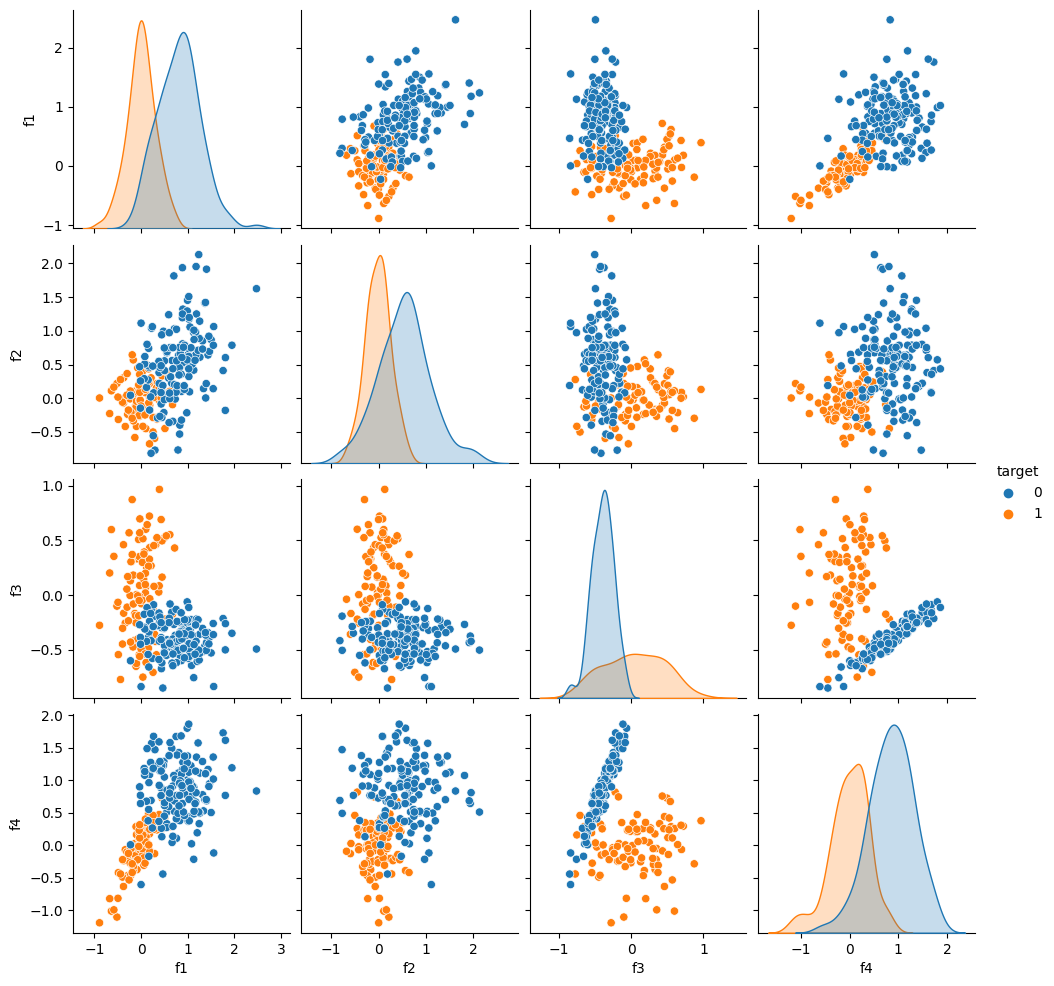

In [227]:
sns.pairplot(data_frame, hue='target');

### 2. Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.

**Задаём:** 
1. число экспериментов равно 100
2. объем обучающей выборки 200 (распределение классов 50/50)
3. объекм тестовой выборки 20000 (аналогично)
4. Число разбиений для скользящего контроля (т.е. кросс-валидации) равно 5

In [228]:
def emp_risk(y_gt, y_pred):
  return 1.0 - accuracy_score(y_gt, y_pred)

def make_experiment(clf, experiments_num=100, train_size=100, test_size=10000, cv_splits=5):
  result = pd.DataFrame()
  result['train emp-risk']     = np.zeros(experiments_num)
  result['CV train emp-risk']  = np.zeros(experiments_num)
  result['test emp-risk']      = np.zeros(experiments_num)
  
  gen = SampleGenerator()
  
  for i in range(experiments_num):
    X_train, y_train = gen.gen_samples(train_size, train_size)
    X_test, y_test = gen.gen_samples(test_size, test_size)
    
    cur_clf = clone(clf)
    cur_clf.fit(X_train, y_train)
    
    #result['Num'][i]               = i
    result['train emp-risk'][i]    = emp_risk(y_train, cur_clf.predict(X_train))
    result['CV train emp-risk'][i] = 1 - np.mean(cross_val_score(clf, X_train, y_train, cv=cv_splits))
    result['test emp-risk'][i]     = emp_risk(y_test, cur_clf.predict(X_test))
  
  return result

3. Повторять шаги 4–7 заданное число раз (50–100).
4. Сгенерировать обучающую выборку заданного размера.
5. Построить решающую функцию. Вычислить эмпирический риск (число ошибок на обучении).
6. Сгенерировать контрольную выборку достаточно большого размера (больше 10000 объектов). Вычислить оценку вероятности ошибочной классификации.
7. Вычислить оценку вероятности ошибочной классификации методом скользящего экзамена (на исходной обучающей выборке).


## Задаём набор исследуемых классификаторов 

In [229]:
CLASSIFIERS = [
  GradientBoostingClassifier(n_estimators=20, random_state=0),
  DecisionTreeClassifier(random_state=42, max_depth=100),
  LogisticRegression(random_state=0),
  QuadraticDiscriminantAnalysis()
]

In [230]:
exp_result = make_experiment(CLASSIFIERS[0])
exp_result

,train emp-risk,CV train emp-risk,test emp-risk
0,0.015,0.055,0.05800
1,0.020,0.075,0.05265
2,0.015,0.095,0.04870
3,0.000,0.040,0.05925
4,0.015,0.060,0.06755
...,...,...,...
95,0.005,0.035,0.06540
96,0.015,0.050,0.04290
97,0.000,0.080,0.05220
98,0.015,0.040,0.06120


## Отображаем результаты эксперимента для **градиентного бустинга**

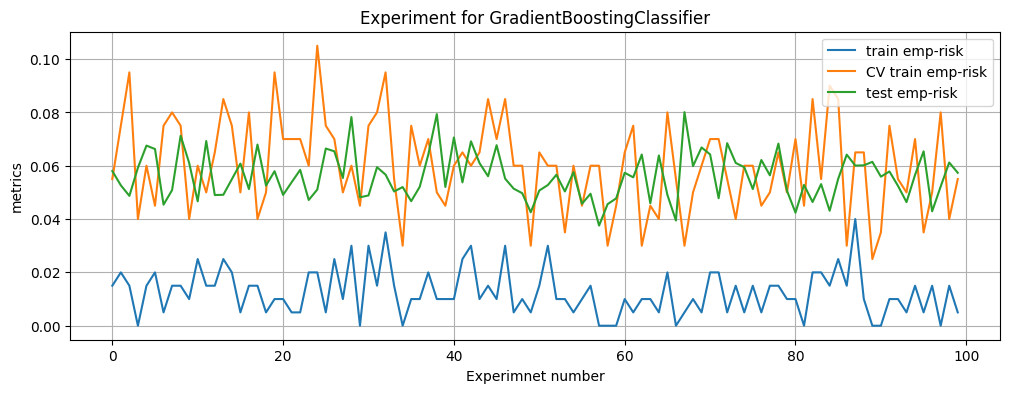

In [231]:
exp_result.plot(
  grid=True, 
  figsize=(12, 4), 
  xlabel='Experimnet number',
  ylabel='metrics',
  title= f'Experiment for {type(CLASSIFIERS[0]).__name__}'
);

In [232]:
def calc_statistics(exp_results):
  result = pd.DataFrame()

  result['mean'] = exp_results.mean()
  result['std'] = exp_results.std()

  return result

In [233]:
calc_statistics(exp_result)

,mean,std
train emp-risk,0.012500,0.008572
CV train emp-risk,0.060150,0.017063
test emp-risk,0.056053,0.008652


Заметим, что *train emp-risk* имеет выраженное смещение на 0.05 по сравнению с *test emp-risk*, но разброс потчи такой же.

*Croos-validation train emp-risk* не имеет выраженного смещения относительно *test emp-risk*, но имеет вдвое больший разброс. Объяснить последнее можно тем, что обучение в этом случае происходит на ещё меньшей выборке, чем исходная обучающая выборка. 

Как итог, лучшей метрикой является *test emp-risk*, причём измеряемая желательно на выборке размера много больше чем обучающая. Но такое возможно только с синтетическими данными. В реаьных задачах подбных больших валидационных выборок нет, т.к. данных может быть исходно не очень много. 
Поэтому *Croos-validation train emp-risk* является более удачным критерием, чем просто emp-risk, т.к. не имеет смещения относительно истинной вероятности предсказания классифкатра

In [234]:
mean_stats = pd.DataFrame()
std_stats = pd.DataFrame()


for clf in CLASSIFIERS:
  clf_name = type(clf).__name__
  statsistics = calc_statistics(make_experiment(clf))
  
  mean_stats[clf_name] = statsistics['mean']
  std_stats[clf_name] = statsistics['std']


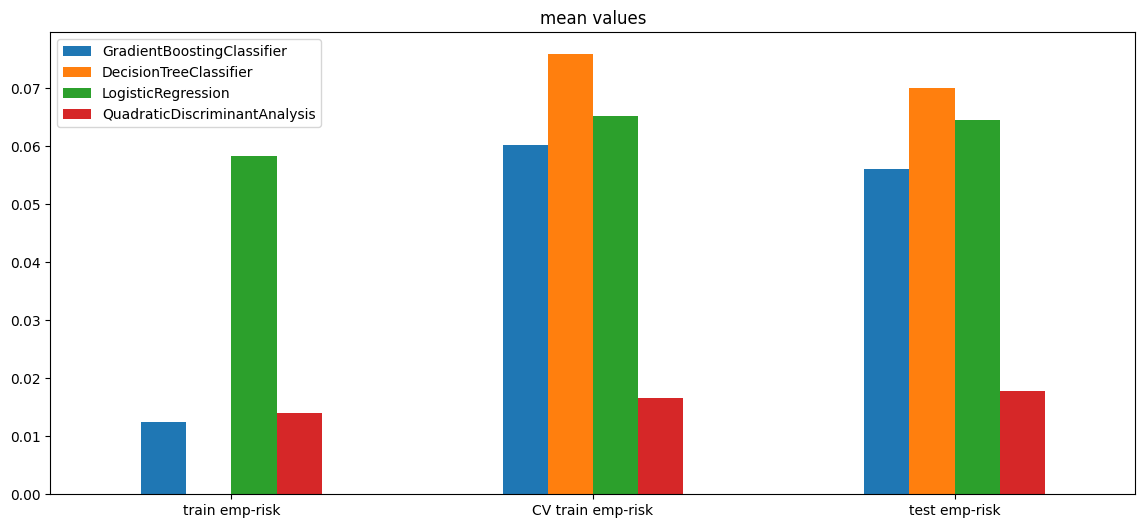

In [235]:
mean_stats.plot(title='mean values', kind='bar', rot=0, figsize=(14, 6));

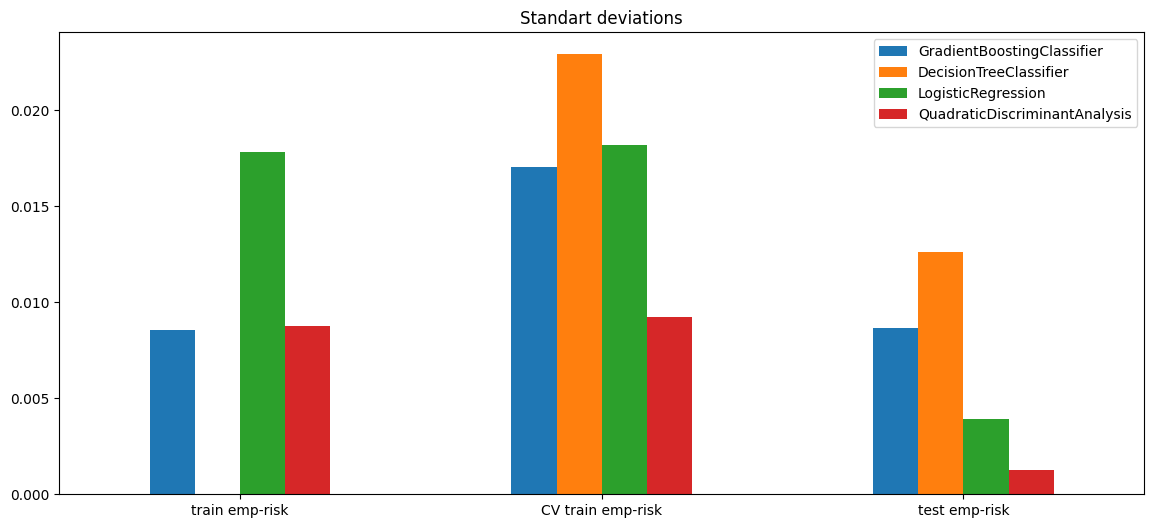

In [236]:
std_stats.plot(title='Standart deviations', kind='bar', rot=0, figsize=(14, 6));

## Анализ полученных результатов

1. GradientBoosting: ансамбль решающих дерьевьев, каждое из которых обучается на основании результата предыдущего. Один из лучших методов, но для хорошей работы нужно правильно подобрать гиперпараметры. В данном случае нарочно, выбраны не самые лучшие параметры, чтобы не было эффекта полного запоминания обучаующей выборки как у глубокого решающего дерева.

2. DecisionTree: специально выбрано берево большой глубины, чтобы показать эффект переобучения. Как видим, не смотря на нулевой эмпирический риск на обучающей выборке, дерево показывает худшие результаты по остальным, более "объективным" метрикам


3. Лог регрессия - линейная модель, поэтому ожидается не сильно впечатляющий результат, т.к. классы линейно не разделимы

4. QDA: Квадратичный дискриминатор, классификатор, предполагающий, что функции условной плотности вероятности классов являются Гауссовыми. Учитывая, что наши данные сгенерированны по гауссову  распределению ожидалось, что данный классификатор покажет один из лучших результатов. Что мы собственно и видим

